In [ ]:
!pip install tensorflow

## Cargar imágenes

In [1]:
# conectar con google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Acceder a la carpeta donde están las imágenes y de donde las leeremos para entrenar el modelo

data_path = "/content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted/"

In [ ]:
from pathlib import Path
import imghdr

data_path = "/content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted"

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

n_images = 0
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            n_images += 1

print(f"Total not valid images: {n_images}")

/tmp/ipython-input-3-4119615236.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Total not valid images: 0


## Preprocesamiento

In [ ]:
import tensorflow as tf

IMG_SIZE = 64
BATCH_SIZE = 128

# Load dataset (no labels)
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest'
)

# Data augmentation function
def augment(image):
    # Random flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (approx. 15 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness & contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Optional: random crop and resize back
    # image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 10, IMG_SIZE + 10)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    return image

def augment_batch(batch):
    return tf.map_fn(augment, batch)

dataset = dataset.map(augment_batch)  # Map the augment_batch function to the dataset
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 127.5 - 1.0)

# Shuffle and prefetch
dataset = dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1843 files.


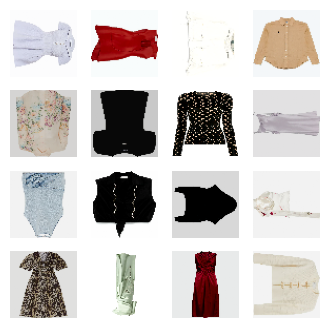

In [ ]:
import matplotlib.pyplot as plt

# Ejemplo para mostrar un batch de imágenes antes del entrenamiento
for images in dataset.take(1):
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        img = images[i].numpy()
        plt.imshow((img + 1) / 2)  # Si están en [-1, 1]
        plt.axis('off')
    plt.show()


## Generador y discriminador

In [ ]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    # initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


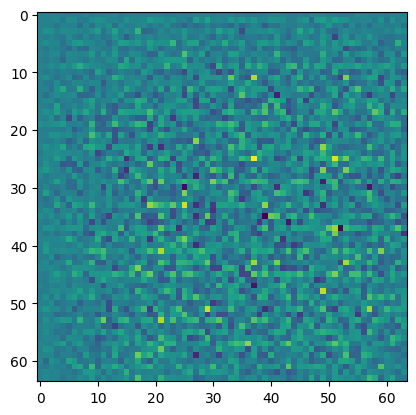

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-8.3262275e-06]], shape=(1, 1), dtype=float32)


## Pérdida

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 1 = real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 0 = fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # queremos engañar al disc

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Parámetros
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# Semilla fija para visualizar progreso
seed = tf.random.normal([num_examples_to_generate, noise_dim])


## Entrenamiento

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import time
import os

# Función para generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1) / 2.0  # Reescala si está en [-1, 1]
        # Ensure the image data is a valid numeric type before displaying
        img_data = img.numpy().squeeze()
        if img_data.dtype == 'object':
            # If dtype is object, likely an empty image, skip or handle appropriately
            print(f"Warning: Image {i} has dtype 'object' and cannot be displayed.")
            continue  # Skip this image
        # Convert to a suitable dtype if necessary
        # img_data = img_data.astype(np.float32)
        plt.imshow(img_data)
        plt.axis('off')

    save_path = os.path.join(output_dir, f'image_at_epoch_{epoch:03d}.png')
    plt.savefig(save_path)
    plt.close()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generar imágenes
        generate_and_save_images(generator, epoch + 1, seed)
        # if (epoch + 1) % 15 == 0:
        #   checkpoint.save(file_prefix = checkpoint_prefix)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}, Time: {time.time()-start:.2f}s')

    # Imagen final
    generate_and_save_images(generator, epochs, seed)


In [ ]:
train(dataset, EPOCHS)

Epoch 1, Gen Loss: 0.6644, Disc Loss: 1.4652, Time: 17.82s
Epoch 2, Gen Loss: 0.6664, Disc Loss: 1.4188, Time: 14.96s
Epoch 3, Gen Loss: 0.7092, Disc Loss: 1.3651, Time: 14.26s
Epoch 4, Gen Loss: 0.6340, Disc Loss: 1.5035, Time: 13.84s
Epoch 5, Gen Loss: 0.6913, Disc Loss: 1.3874, Time: 13.66s
Epoch 6, Gen Loss: 0.6625, Disc Loss: 1.4226, Time: 14.10s
Epoch 7, Gen Loss: 0.6859, Disc Loss: 1.3874, Time: 14.72s
Epoch 8, Gen Loss: 0.6930, Disc Loss: 1.4140, Time: 15.00s
Epoch 9, Gen Loss: 0.6882, Disc Loss: 1.4334, Time: 15.02s
Epoch 10, Gen Loss: 0.7147, Disc Loss: 1.3990, Time: 14.89s
Epoch 11, Gen Loss: 0.6835, Disc Loss: 1.3948, Time: 15.49s
Epoch 12, Gen Loss: 0.7165, Disc Loss: 1.4209, Time: 14.69s
Epoch 13, Gen Loss: 0.6681, Disc Loss: 1.4086, Time: 14.12s
Epoch 14, Gen Loss: 0.6805, Disc Loss: 1.4069, Time: 13.77s
Epoch 15, Gen Loss: 0.6182, Disc Loss: 1.4701, Time: 13.87s
Epoch 16, Gen Loss: 0.7213, Disc Loss: 1.3654, Time: 14.46s
Epoch 17, Gen Loss: 0.7545, Disc Loss: 1.3757, Ti

## Guardar imágenes

In [ ]:
import os

destination_folder = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_data_augmentation'
os.makedirs(destination_folder, exist_ok=True)

import shutil

source_folder = 'generated_images'  # carpeta local en Colab
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_data_augmentation'

## Mostrar resultados

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Extraer los archivos .png y el número en su nombre
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else -1

# Filtrar y ordenar archivos por número extraído
def filter_and_sort_files(dir, n):
  png_files = [f for f in os.listdir(dir) if f.endswith('.png')]
  png_files = [f for f in png_files if extract_number(f) % n == 0]
  png_files = sorted(png_files, key=extract_number)

  # Mostrar en grid 4x4
  plt.figure(figsize=(12, 12))

  for i, file_name in enumerate(png_files):
      img = mpimg.imread(os.path.join(dir, file_name))
      plt.subplot(5, 5, i + 1)
      plt.imshow(img)
      plt.axis('off')
      plt.title(file_name, fontsize=8)

  plt.tight_layout()
  plt.show()

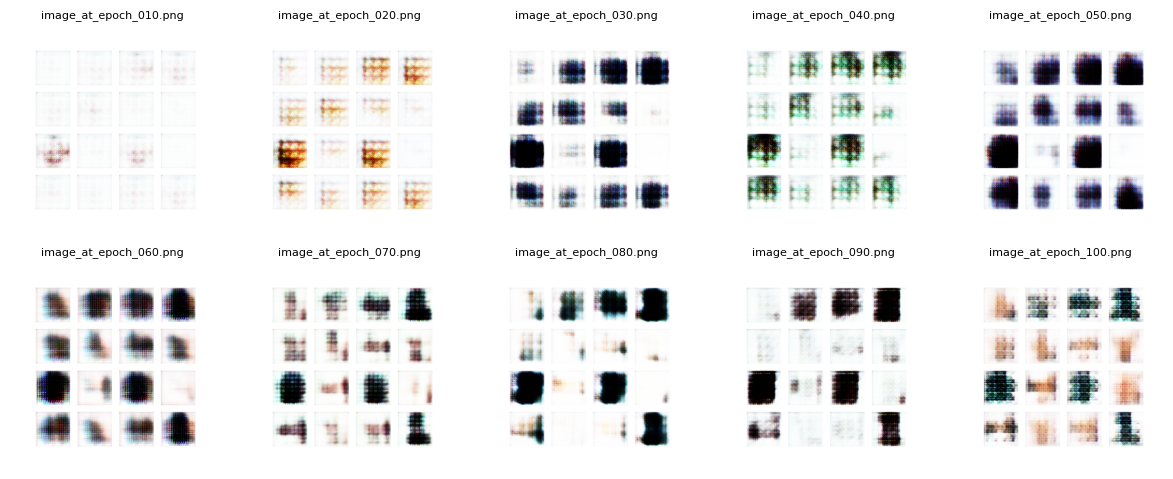

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_data_augmentation'
filter_and_sort_files(dir, 10)

## GIF

In [ ]:
import imageio
import glob
import os

anim_file = 'cvae.gif'
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_data_augmentation'


with imageio.get_writer(anim_file, mode='I') as writer:
  # filenames = glob.glob('image*.png')
  filenames = glob.glob(os.path.join(dir, 'image*.png'))
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipython-input-21-4098110209.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
